# Train on Conditional PMFs P(m|n)


First, load in modules.

In [1192]:
import numpy as np
import time
from scipy import stats
import matplotlib.pyplot as plt

import torch
import train_conditional_mc as trc
import tools_conditional as ttc

Next, load in data. Data for conditional PMF training is stored in : 

1. '/home/mcarilli/CME/conditional_training_data'


'Parameter' vectors are stored as {$\textrm{log}_{10}(b), \textrm{log}_{10}(\beta),\textrm{log}_{10}(\gamma),n$},
where $n$ is the nascent RNA count at which to calculate the conditional distribution P(m|n).

In [1193]:
path = '/home/mcarilli/CME/conditional_training_data2/'

In [1038]:
train_list,test_list = trc.get_file_paths(set_size = 256,
                                number_of_training_files=2,
                                 number_of_testing_files=1,total_files=11,file_path=path)

Calculating ypred at runtime! 

In [1116]:
npdf = 10

def get_NORM(npdf,quantiles='lin'):
    if quantiles == 'lin':
        q = np.linspace(0,1,npdf+2)[1:-1]
        NORM = stats.norm.ppf(q)
        NORM = torch.tensor(NORM)
        return NORM
    if quantiles == 'cheb':
        n = np.arange(npdf)
        q = np.flip((np.cos((2*(n+1)-1)/(2*npdf)*np.pi)+1)/2)

        NORM = stats.norm.ppf(q)
        NORM = torch.tensor(NORM)
        return NORM

def generate_grid(logmean_cond,logstd_cond):

    translin = torch.exp(logmean_cond+logstd_cond*NORM)
    return translin


def get_ypred_at_RT(p,w,hyp,npdf=npdf,log=False,array=False):
    '''Given a parameter vector (tensor) and weights (tensor), and hyperparameter,
    calculates ypred (Y) at runtime.'''

#     if log:
#         n = torch.exp(p[3])-1
#     else:
#         n = p[3]
        
#     p_vec = 10**p[:-1]
    
#     # mean, variance, standard deviation of exact (2D) solution
#     MU, VAR, STD, xmax = trc.get_moments(p_vec)
    
#     COV = p_vec[0]**2/(p_vec[1] + p_vec[2])
    
# #     # unpack mean, variance, STD for nascent and mature RNA 
#     xmax_m = xmax[1]
#     grid = generate_grid(npdf,VAR,MU,COV,n)
    
    p_vec = 10**p[0:3]
    logmean_cond = p[3]
    logstd_cond = p[4]
    xmax_m = p[5].int()
    


    
    grid = generate_grid(logmean_cond,logstd_cond)
#     print(grid)
    
    s = torch.zeros(npdf)
#     s[0] = grid[0]
    s[:-1] = torch.diff(grid)
    s *= hyp
    s[-1] = torch.sqrt(grid[-1])
    
    v = s**2
#     if torch.any(v<grid):
#         v = torch.maximum(v,grid)
    r = grid**2/(v-grid)
    p_nb = 1-grid/v
    
#     r = (grid/s)**2 
#     p_nb = 1/(1+s**2/grid)
    xgrid = torch.arange(xmax_m+1)
    Y = torch.zeros(xmax_m+1)
    if array == True:
        Y_array = torch.zeros((npdf,xmax_m+1))
    GAMMALN_XGRID = lnfactorial[1:len(xgrid)+1]
    
    for i in range(npdf):
        l = -grid[i] + xgrid * torch.log(grid[i]) - GAMMALN_XGRID
        if (p_nb[i] >1e-10):
            l += torch.special.gammaln(xgrid+r[i]) - torch.special.gammaln(r[i]) \
                - xgrid*torch.log(r[i] + grid[i]) + grid[i] \
                + r[i]*torch.log(r[i]/(r[i]+grid[i]))
        Y += w[i]*torch.exp(l)
        if array == True:
            Y_array[i] = w[i]*torch.exp(l)
        #Y += torch.log(w[i])+l

#     for i in range(npdf):
#         l = torch.special.gammaln(xgrid+r[i]) - GAMMALN_XGRID - torch.special.gammaln(r[i]) \
#             + xgrid*torch.log(1-p_nb[i]) + r[i]*torch.log(p_nb[i])
    
#         Y += w[i]*torch.exp(l)
    EPS = 1e-40
    Y[Y<EPS]=EPS
    if array == True:
        Y_array[Y_array<EPS] = EPS
        return Y_array
    
    return Y


Define NORM quantiles and lnfactorial.

In [1041]:
NORM = get_NORM(npdf,quantiles='cheb')

# precalculate lngammas
lnfactorial = torch.special.gammaln(torch.arange(1003))

For cleaner training, set up model configurations and training configurations to pass to train. 

Model is 2 hidden layers, with user-defined dimensions.

Input dimension is 4 ('param vector' and n value), and output is npdf.

In [1220]:
model_config = {
    'npdf' : 10,
    'input_dim' : 7,
    'h1_dim' : 256,
    'h2_dim' : 256,
    'norm_type' : 'softmax',
    'num_training_params': 10000, #is this ever actually used? -- yes, in metadata,
    'quantiles' : 'cheb'
}

train_config = {
    'num_epochs' : 10,
    'lr' : 1e-3,
    'batchsize' : 100,
    'metric' : 'kld',
}

norm_type options:
    1. 'softmax'
    2. 'normalize' (applies sigmoid so all are positive, then normalizes)
    3. None (takes absolute value of output weights)
   
metric options:
    1. 'kld'
    2. 'kld_normalized'
    3. 'totalse'
    4. 'mse'
    5. 'maxabsdev'
    6. 'maxabsdevlog'
    7. 'mselog'
    

## And Train

In [1217]:
t1 = time.time()
e,t,model = trc.train(train_list[0:10000],test_list[0:400],model_config,train_config,get_ypred_at_RT)
t2 = time.time()
dt = t2-t1
print(t2-t1)

Epoch Number: 0
Epoch Number: 1
Epoch Number: 2
Epoch Number: 3
Epoch Number: 4
Epoch Number: 5
Epoch Number: 6
Epoch Number: 7
Epoch Number: 8
Epoch Number: 9
406.3810784816742


Save the model and meta data.

Will save two files: 
    1. 'path/name_MODEL'
    2. 'path/name_meta.npy'

In [453]:
path1 = './models/'

# ttc.save_model_and_meta(model,model_config,train_config,time,path,name)

#example:
# ttc.save_model_and_meta(model,model_config,train_config,time=dt,path=path1,name='220420_model1')

Then, to load it in, I have defined a class Trained_Model.

This includes:
    1. example_model.model_configs (dictionary of model configurations) 
    2. example_model.train_configs (dictionary of training configurations)
    3. example_model.time (time it took to train)
    4. example_model.model (actual model)
    

In [454]:
# example_model = ttc.Trained_Model(path, name)

-----

## Validation and Plotting

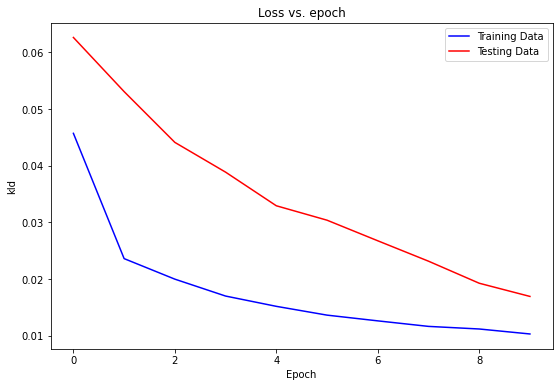

In [1221]:
ttc.plot_training(e,t,metric='kld')

In [1055]:
metrics,metric_mean = trc.calculate_test_metrics(test_list[1000:2000],model,get_ypred_at_RT,metric='kld')

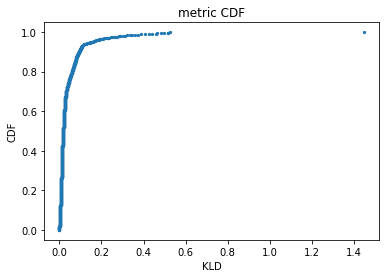

In [1056]:
ttc.plot_CDF(metrics)

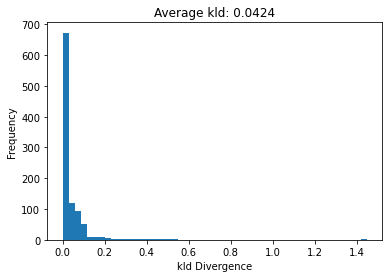

In [1210]:
ttc.plot_histogram(metrics,bins=50,metric='kld')

In [1057]:
p_list,y_list = trc.unpack_data(train_list)

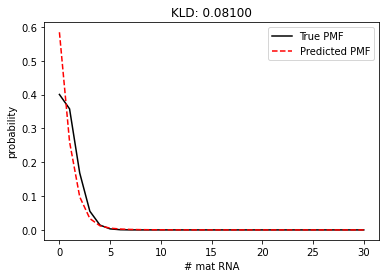

In [1058]:
j = 90
ttc.plot_PMF(p_list[j:j+1],y_list[j:j+1],model,npdf,get_ypred_at_RT,kld=True)

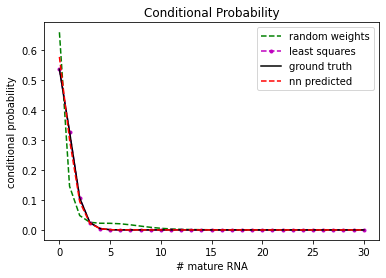

In [1223]:
# ttc.plot_rand(position,npdf,train_list,model,get_ypred_at_RT,rand=False,unif=False,ls=False,norm_nnls=False)
ttc.plot_rand(80,10,train_list,model,get_ypred_at_RT,rand=True,unif=False,ls=True,norm_nnls=False)

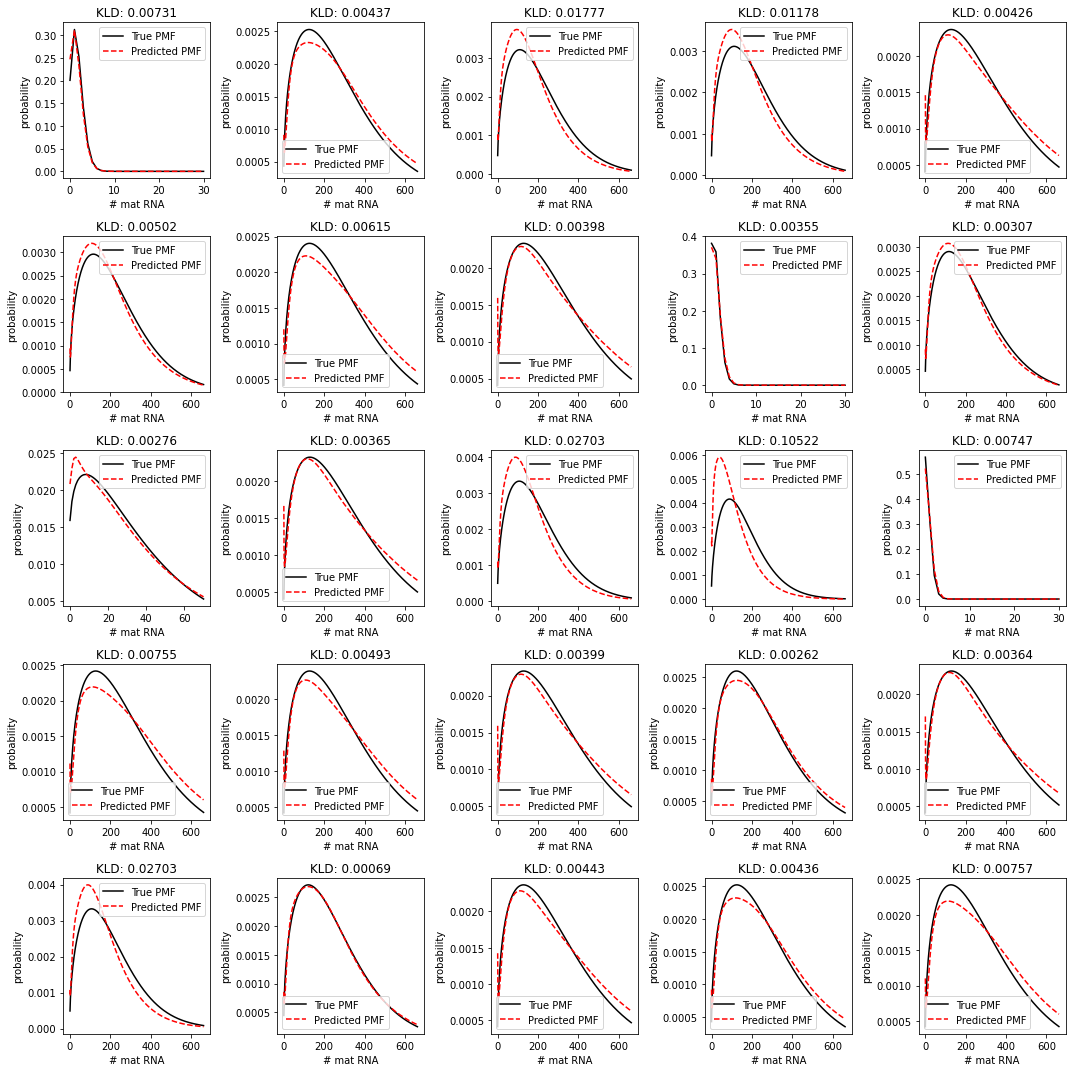

In [1225]:
ttc.plot_PMF_grid(train_list[:500],npdf,5,5,model,get_ypred_at_RT,kld=True,normalize=True)

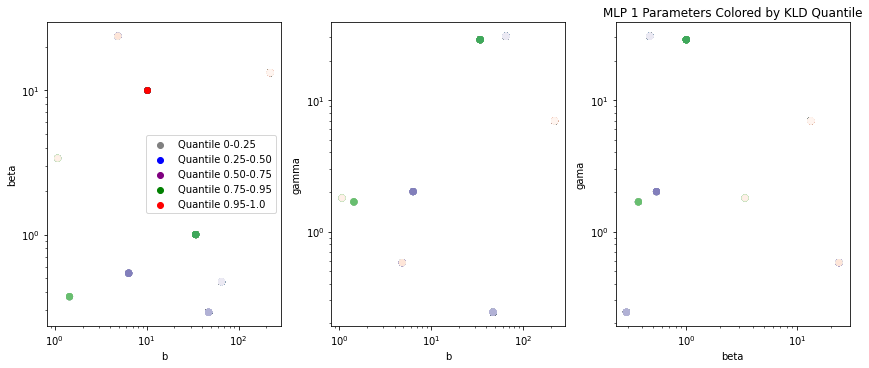

In [1214]:
ttc.plot_param_quantiles(klds=metrics,train_list=test_list[1000:2000],model=model)